In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.signal import butter, filtfilt
# the imports below only work when this notebook file is directly placed in mlicms2425ex5-groupg
from src.systems.utils import *
from src.models.approximator import *
from src.models.utils import *
from src.models.time_delay import *

Load data

In [2]:
path = './data/MI_timesteps.txt'
data = np.loadtxt(path)
print(data.shape)

(15001, 10)


Extract the first 3 measurements and perform the time-delay embedding

In [3]:
# Extract columns 2, 3, 4 (measurement areas) after skipping the burn-in period
data_3_measurements = data[1000:, 1:4]  # Skip first 1000 rows, keep columns 2, 3, 4

# Note that for TimeDelayEmbedding to work, you have to comment out lines 35 and 36 in time_delay.py (last 2 lines of method _post_init_)
# Initialize the time-delay embedding class
time_delay_embedding = TimeDelayEmbedding(time_delay=350)  # 350 delays

# Perform the time-delay embedding
embedded_data = time_delay_embedding.transform(data_3_measurements)
print("Shape of Embedded Data:", embedded_data.shape)

Shape of Embedded Data: (13651, 1053)


Do PCA embedding with at least 95% of explained variance required, and use the first 3 principle components 

In [4]:
needed_explained_variance_ratio = 0.95
pca = PCA(n_components=needed_explained_variance_ratio,  svd_solver='full')
pca_transformed = pca.fit_transform(embedded_data)

# Retain the first 3 components for visualization
embedding_dim = 3
reduced_state_space = pca_transformed[:, :embedding_dim]  

print(f"for at least {needed_explained_variance_ratio*100}% of explained variance ratio, {pca.n_components_} components are needed")
print("Shape of Reduced State Space:", reduced_state_space.shape)

for at least 95.0% of explained variance ratio, 6 components are needed
Shape of Reduced State Space: (13651, 3)


visualize the 3D PCA embedding

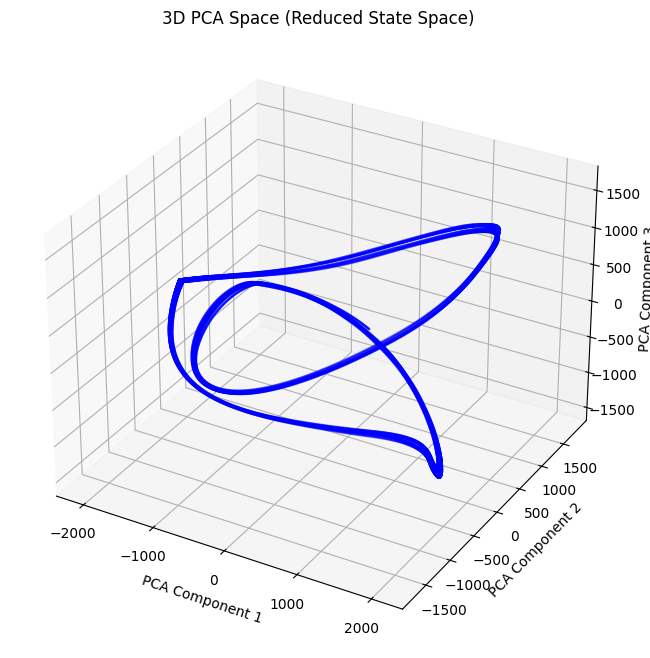

In [5]:
x_pca = reduced_state_space


# 3D Scatter Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot PCA components
ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], s=1, c='b', alpha=0.5)
# Set labels and title
ax.set_title('3D PCA Space (Reduced State Space)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

plt.show()

Color the PCA embeddings according to the measurement locations

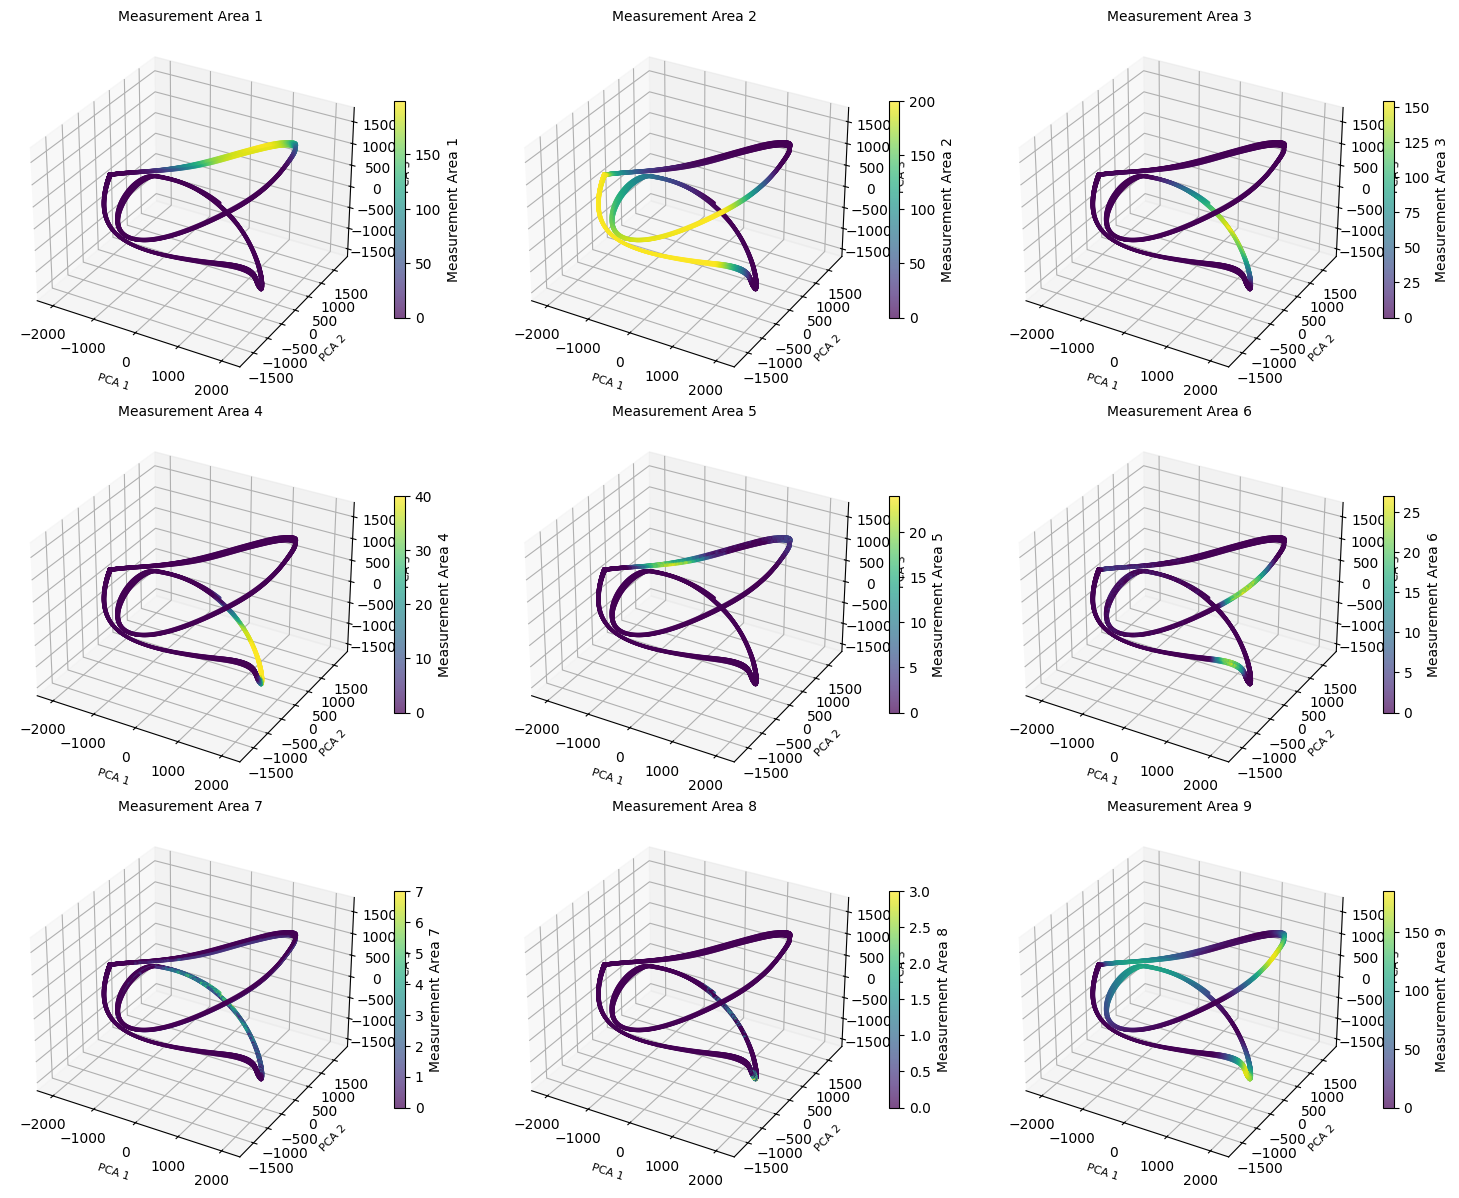

In [6]:
x_original = data[1000:1000 + x_pca.shape[0], 1:]


# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 12), subplot_kw={'projection': '3d'})
# Flatten the axes array for easy iteration
axes = axes.flatten()
for i in range(9):  # Loop over the nine measurement areas
    ax = axes[i]  # Select the subplot for this plot
    # 3D scatter plot
    scatter = ax.scatter(
        x_pca[:, 0], x_pca[:, 1], x_pca[:, 2],  # PCA components 1, 2, and 3
        s=1, c=x_original[:, i], cmap='viridis', alpha=0.7  # Color by the i-th measurement area
    )
    # Add colorbar
    cbar = fig.colorbar(scatter, ax=ax, shrink=0.6)
    cbar.set_label(f'Measurement Area {i + 1}')
    # Set labels and title
    ax.set_title(f'Measurement Area {i + 1}', fontsize=10)
    ax.set_xlabel('PCA 1', fontsize=8)
    ax.set_ylabel('PCA 2', fontsize=8)
    ax.set_zlabel('PCA 3', fontsize=8)
# Adjust layout
plt.tight_layout()
plt.show()

Compute Arclength in 3D case directly

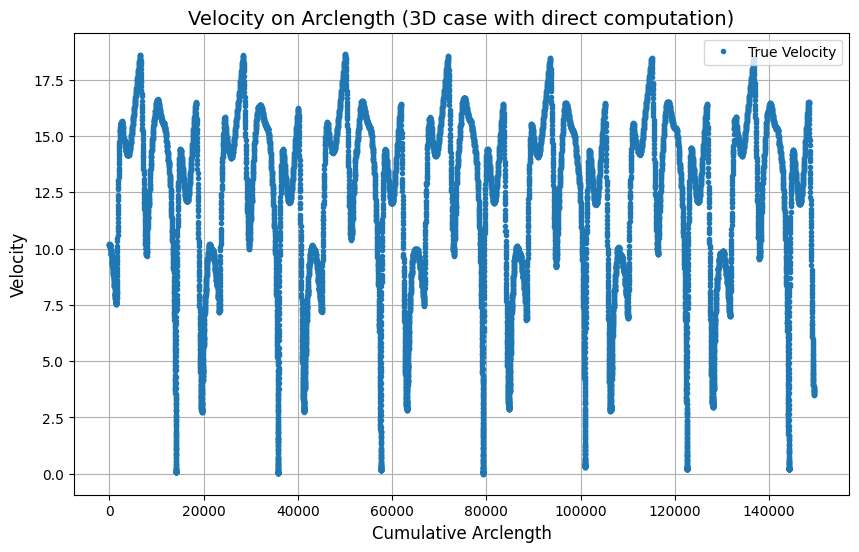

In [7]:
#Compute Arclength in 3D case
differences = np.diff(x_pca, axis=0)  # Differences in PCA space
distances = np.linalg.norm(differences, axis=1)  # Euclidean distances
arclength = np.cumsum(distances)  # Cumulative sum of distances
arclength = np.insert(arclength, 0, 0)  # Start at 0 for the first point

#Compute Velocity Directly at Points
velocity = np.gradient(arclength)  # Gradient gives velocity directly at points

# Plot the Velocity Field
plt.figure(figsize=(10, 6))
plt.plot(arclength, velocity, 'o', label='True Velocity', markersize=3)  # True velocity
plt.title('Velocity on Arclength (3D case with direct computation)', fontsize=14)
plt.xlabel('Cumulative Arclength', fontsize=12)
plt.ylabel('Velocity', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Compute Arclength as the combination of 3 orthogonal components, i.e. as the sum of 3 orthogonal vectors, where each vector is the arclength in one dimension.This is to show that the two methods for getting arclength is equivalent.

dimension wise computation and 3D computation have mse error 7.091801282093457e-08


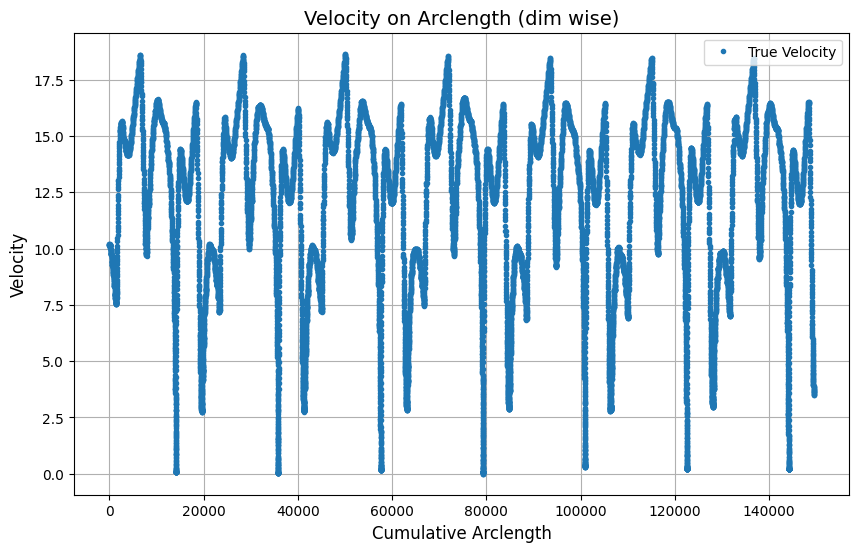

In [8]:
#Compute arclength and velocity dimension wise
arclength_dim_wise = np.cumsum(differences, axis=0)  # Cumulative sum of distances
arclength_dim_wise = np.vstack((np.zeros((1,3)), arclength_dim_wise))

v1 = np.gradient(arclength_dim_wise[:,0])
v2 = np.gradient(arclength_dim_wise[:,1])
v3 = np.gradient(arclength_dim_wise[:,2])

v = np.sqrt(v1**2 + v2**2 + v3**2)
print(f"dimension wise computation and 3D computation have mse error {compute_mse(velocity.reshape(-1,1), v.reshape(-1,1))}")

# Plot the Velocity Field
plt.figure(figsize=(10, 6))
plt.plot(arclength, v, 'o', label='True Velocity', markersize=3)  # True velocity
plt.title('Velocity on Arclength (dim wise)', fontsize=14)
plt.xlabel('Cumulative Arclength', fontsize=12)
plt.ylabel('Velocity', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Trying to get the period by seeing the time difference between 2 max values of first measurement. The time difference is equivalent to the index difference because time gap between two points is one.

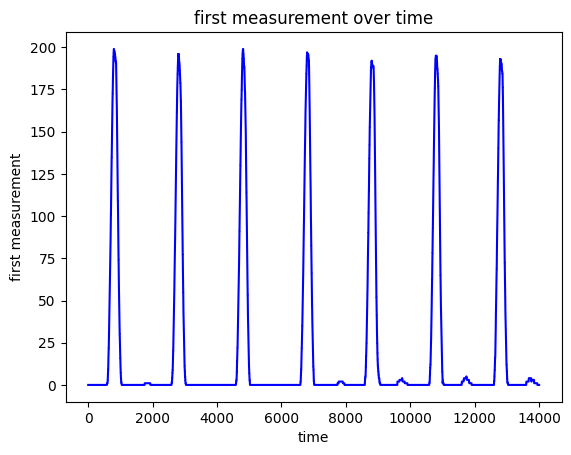

796 2796


In [9]:
first_measurement = data[1000:, 1]
indices = np.arange(len(first_measurement))
first_measurement_with_indices = np.column_stack((indices, first_measurement))
plot_2d_points(first_measurement_with_indices, x_label= 'time', y_label='first measurement', title='first measurement over time')

# get an approximate index-period of 1st meausrement
print(np.argmax(first_measurement[:2000]), np.argmax(first_measurement[2000:4000])+2000)

# period is around 2796-796 = 2000 indices in first measurement
peroid = int(2000)

rbf_vector_field is an RBFApproximator that learns to get v (3-dim velocity) with radius

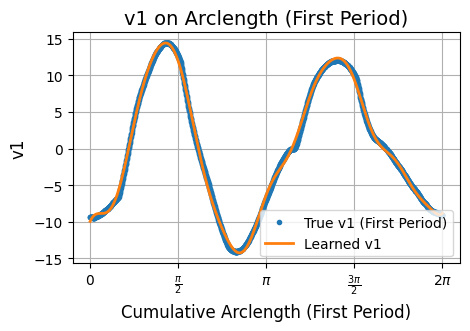

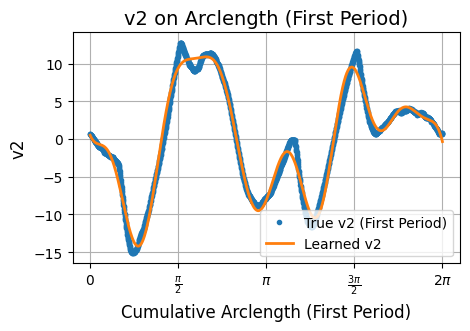

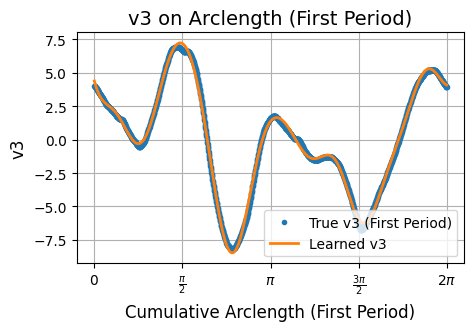

In [10]:
v_period = np.column_stack((v1,v2,v3))[:peroid]

radius_range_period = np.linspace(0,2*np.pi,peroid)
rbf_vector_field = RBFApproximator(L=20, eps=1)  # Adjust L and eps as needed
rbf_vector_field.fit(radius_range_period.reshape(-1,1), v_period)

# Generate Predictions for the first period
# Fine sampling within the first period
arclength_radius_range = np.linspace(0, 2 * np.pi, 10000).reshape(-1, 1)
predicted_v_period = rbf_vector_field.predict(arclength_radius_range)

for i in range(3):
    # Plot the Velocity Field for the first period
    plt.figure(figsize=(5, 3))
    plt.plot(radius_range_period, v_period[:,i], 'o', label=f'True v{i+1} (First Period)', markersize=3)  # True velocity
    plt.plot(arclength_radius_range, predicted_v_period[:,i], '-', label=f'Learned v{i+1}', linewidth=2)

    plt.xticks(
    ticks=np.linspace(0, 2 * np.pi, 5),  # Five evenly spaced ticks from 0 to 2*pi
    labels=[r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]
    )

    plt.title(f'v{i+1} on Arclength (First Period)', fontsize=14)
    plt.xlabel('Cumulative Arclength (First Period)', fontsize=12)
    plt.ylabel(f'v{i+1}', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

rbf_learn_1st_measurement is an RBFApproximator that learns to use v (3-dim velocity) to get the value of the first measurement

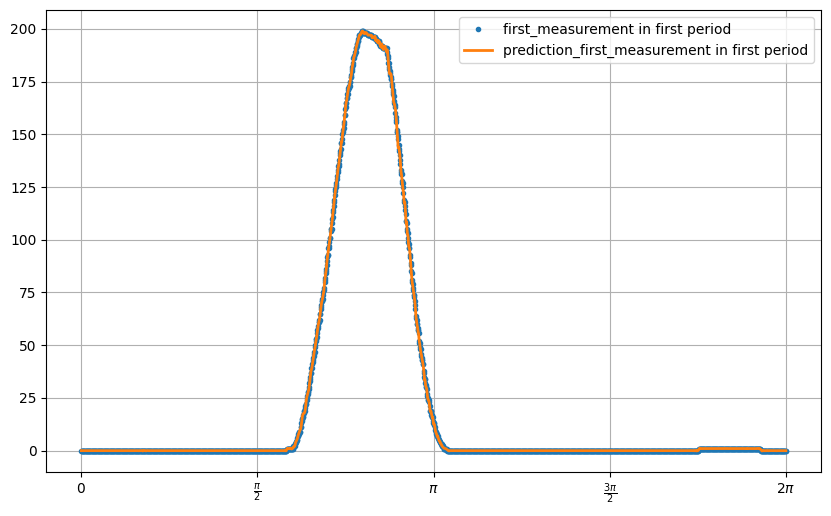

In [11]:
rbf_learn_1st_measurement = RBFApproximator(L=500, eps=1)
rbf_learn_1st_measurement.fit(v_period, first_measurement[:peroid])
prediction_first_measurement = rbf_learn_1st_measurement.predict(v_period)


# Plot the Velocity Field for the first period
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0,2*np.pi, peroid), first_measurement[:peroid], 'o', label=f'first_measurement in first period', markersize=3)  # True velocity
plt.plot(np.linspace(0,2*np.pi, peroid), prediction_first_measurement, '-', label='prediction_first_measurement in first period', linewidth=2)
plt.xticks(
    ticks=np.linspace(0, 2 * np.pi, 5),  # Five evenly spaced ticks from 0 to 2*pi
    labels=[r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]
    )
plt.legend()
plt.grid(True)
plt.show()


Predict the 14 days evaluation by first using radius to get v, then use v to predict the meansurement value. Transform the radius that's outside 0~2*pi to 0~2*pi

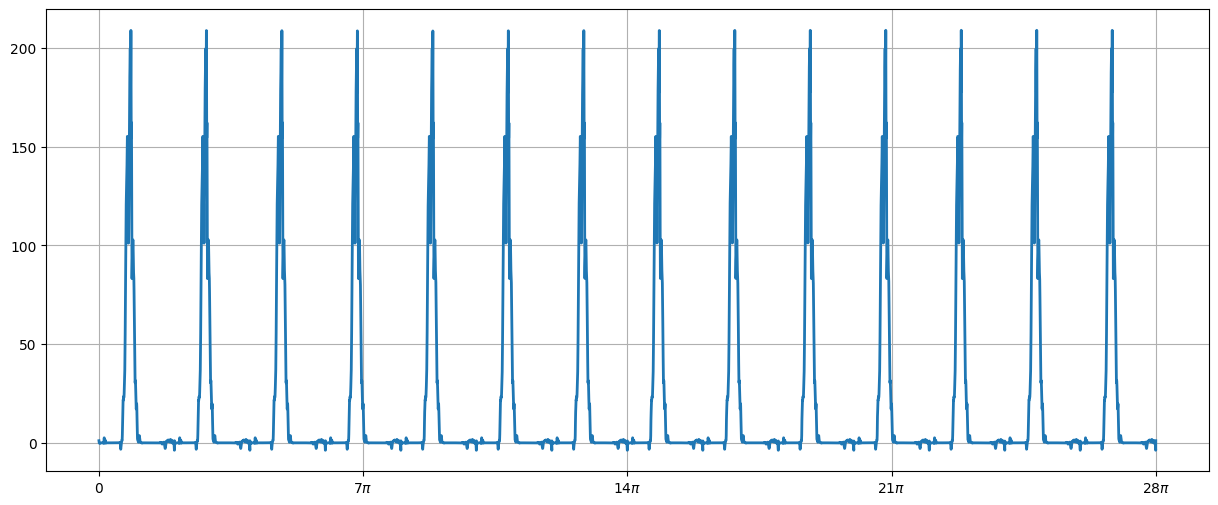

In [12]:
arclength_radius_range_14days = np.linspace(0, 14*2*np.pi, 14*peroid).reshape(-1, 1)
def confine_raduis(M):
    return np.where(M>=2*np.pi, M%(2*np.pi), M)

predicted_v = rbf_vector_field.predict(confine_raduis(arclength_radius_range_14days))
predicted_1st_measurement_14days = rbf_learn_1st_measurement.predict(predicted_v)

horr = arclength_radius_range_14days.flatten()
# Plot the Velocity Field for the first period
plt.figure(figsize=(15, 6))
plt.plot(horr, predicted_1st_measurement_14days, '-', linewidth=2)
plt.xticks(
    ticks=np.linspace(0, 28 * np.pi, 5),  # Five evenly spaced ticks from 0 to 28*pi
    labels=[r"$0$", r"$7\pi$", r"$14\pi$", r"$21\pi$", r"$28\pi$"]
)
plt.grid(True)
plt.show()